In [1]:
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit, least_squares
import re
%matplotlib inline

import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools

import sncosmo
import copy

import pandas as pd

Important functions 

In [2]:
def show_multi_filter_light_curve(t, colors, n_factor = None, conv='.'):
   
    #plt.figure(figsize=(15,10))
    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    #print indices
    for i in range(0, len(indices)-1):
        
        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()
    
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc["id"],lc,slc))


    print len(matches)
    return matches

def mod_gauss(t, a, t0, tf, tr, b):
    return a*((exp(-(t-t0)/tf))/(1+exp(-(t-t0)/tr)))+b

def gauss(x, a, x0, sigma, b):
    return a*exp(-(x-x0)**2/(2*sigma**2))+b


def residuals(p, x, y):
    a, m, s, b = p
    y_fit = gauss(x, a, m, s, b)
    
    err = y - y_fit
    return err

def get_max_index(fluxes):
    max_val = 0
    max_index = -1
    for i, elem in enumerate(fluxes):
        
        if max_val<elem:
            max_val = elem
            max_index = i
            
    return max_index
    
def show_fit_mod_gaussians(t, colors, n_factor = None, plot=True):

    
    t_by_filter = t.group_by("bandpass")

    
    min_date = min(t["mjd"])
    max_date = max(t["mjd"])
    
     
    indices = t_by_filter.groups.indices
    max_i = get_max_index(t_by_filter["flux"])
    mean_date = t_by_filter[max_i]["mjd"]-min_date
    
  
    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        x = data["mjd"]-min_date
        y = data["flux"]
        
        n = len(x)
        sigma = np.std(y)
        
      
        popt, pcov = curve_fit(mod_gauss, x, y, p0=[1, mean_date, 2, 1, 0], maxfev=50000,  sigma = data["flux_error"])
        
        
        c = (y - mod_gauss(x, *popt))
        chi = (y - mod_gauss(x, *popt))/data["flux_error"]
    
        chi2 = (chi**2).sum()
        dof = len(x) - len(popt)

        #print len(x) - len(popt)
        #print (chi2 / (len(x)-len(popt)))
        if plot==True:
            plt.plot(x, y, 'b+', color=colors[data[0]["bandpass"]])

            X = np.arange(0,max_date-min_date,1)

            plt.plot(X, mod_gauss(X, *popt), color=colors[data[0]["bandpass"]])
        #print gauss(X, *popt)
        #plt.xlim(xmin=400, xmax=500)
        #plt.show()
        #plt.legend()
    #plt.show()
    return popt, pcov, chi2, dof


In [7]:
snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}
base_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

In [3]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#elems = re.findall('^(.*?D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
elems = re.findall('^((04|05|06)D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
f.close()

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
f.close()


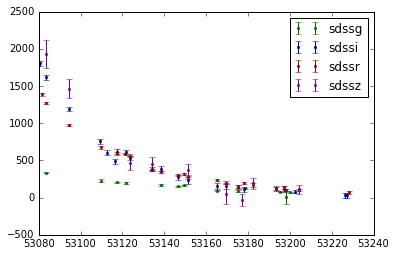

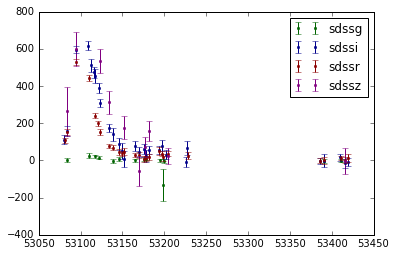

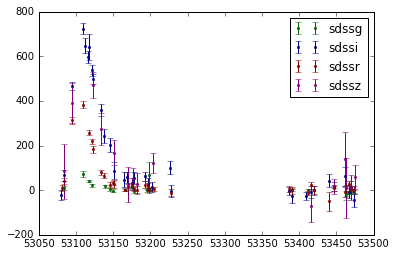

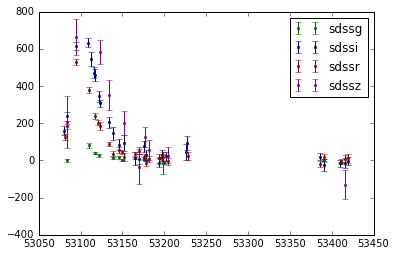

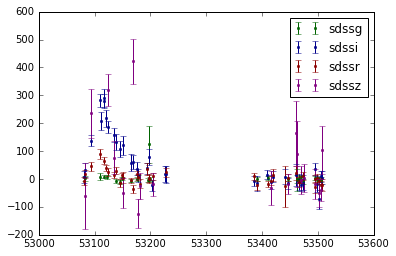

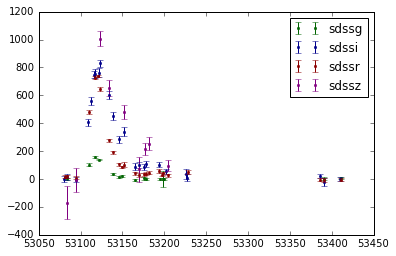

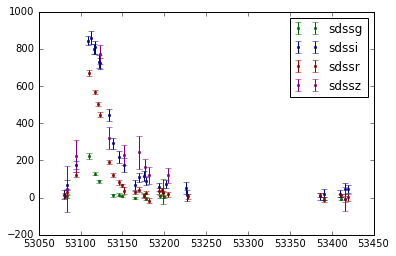

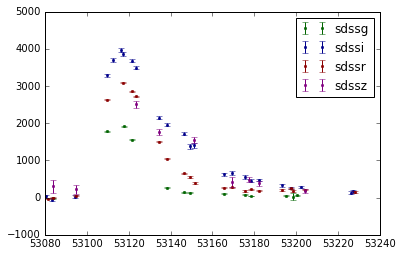

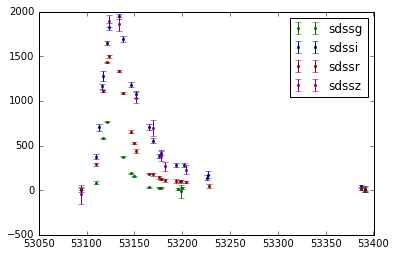

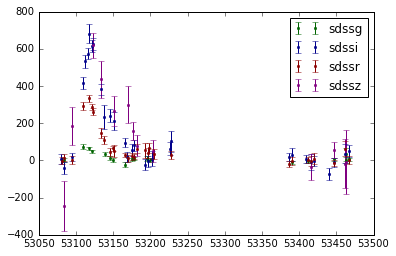

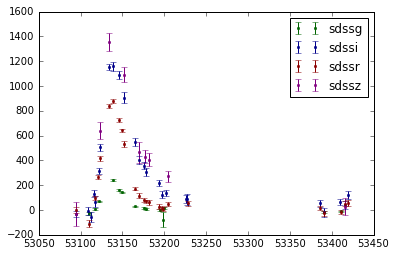

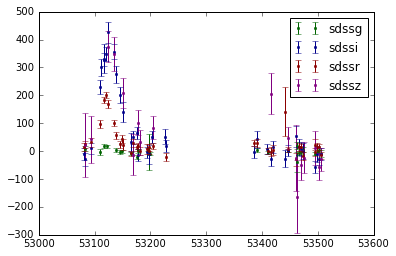

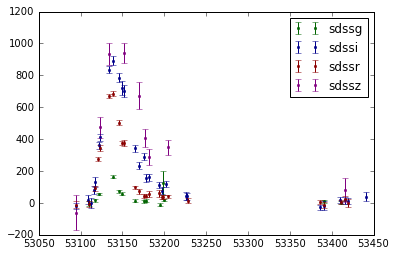

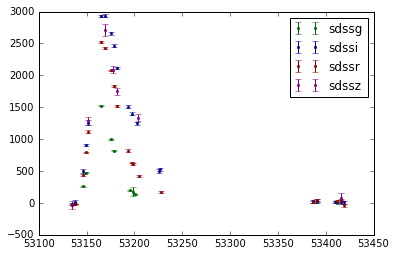

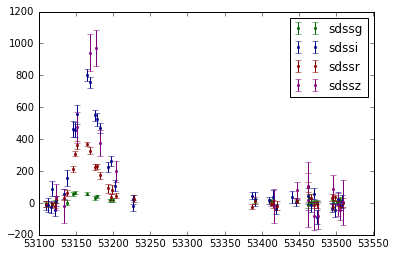

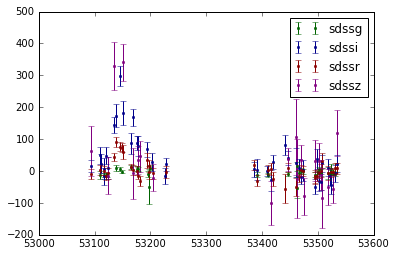

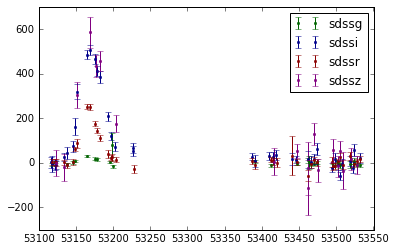

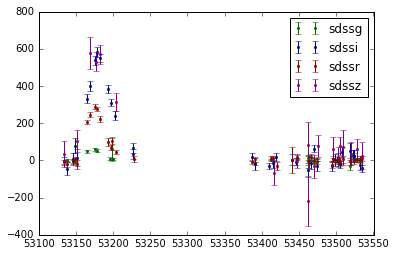

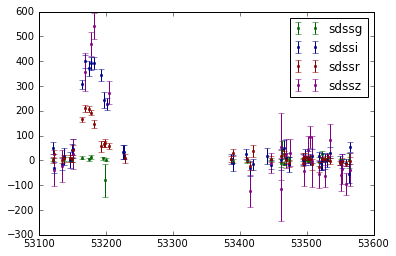

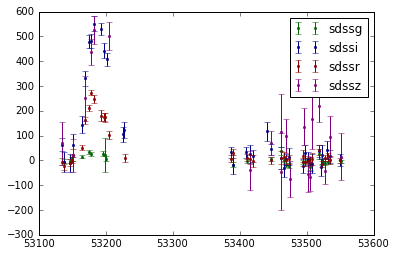

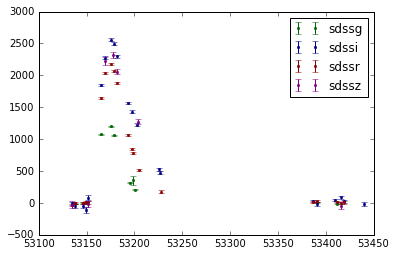

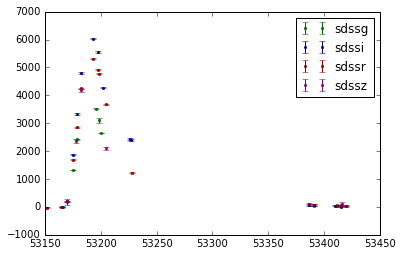

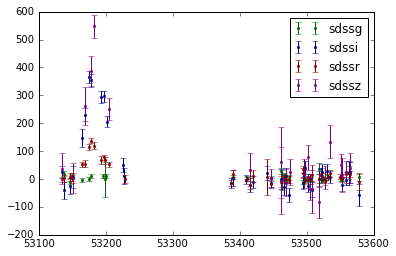

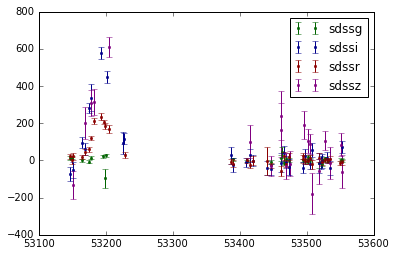

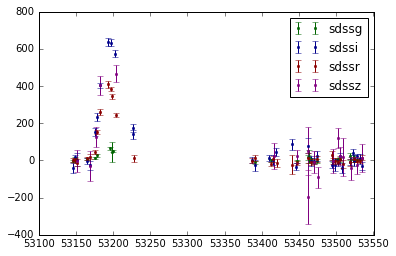

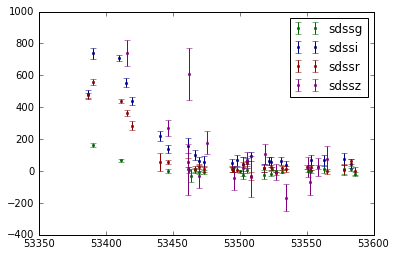

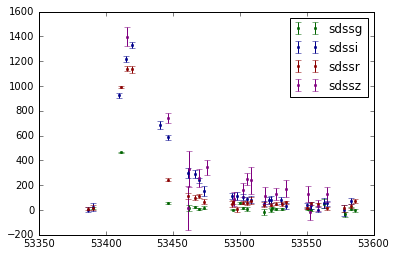

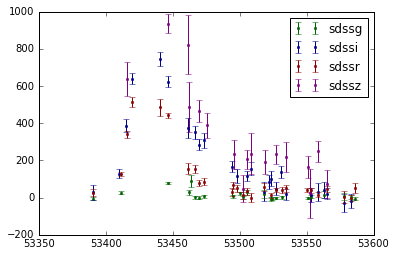

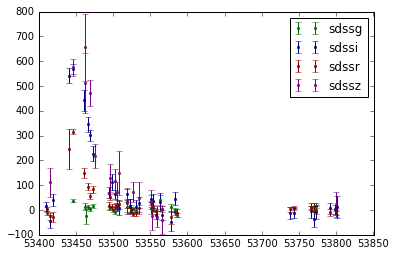

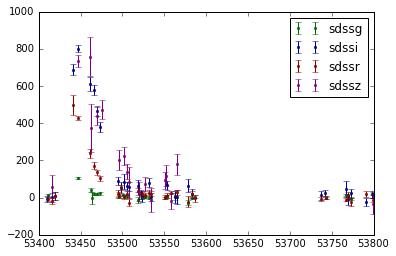

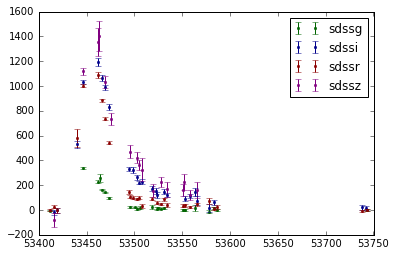

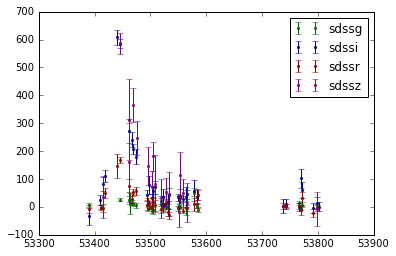

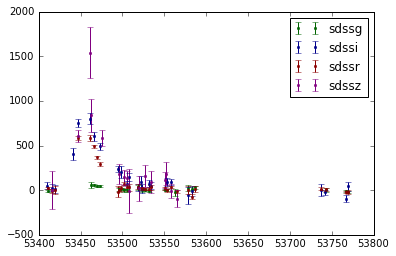

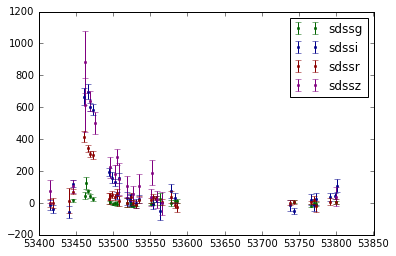

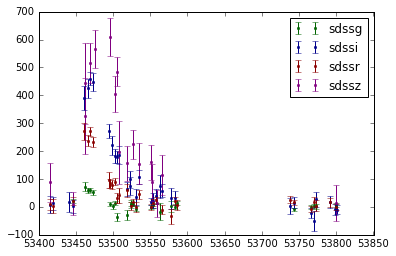

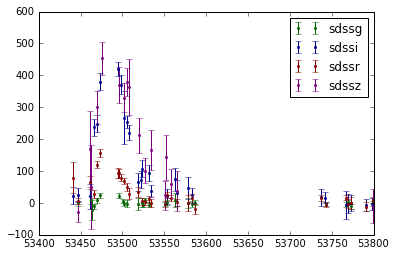

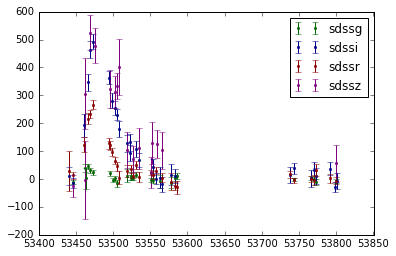

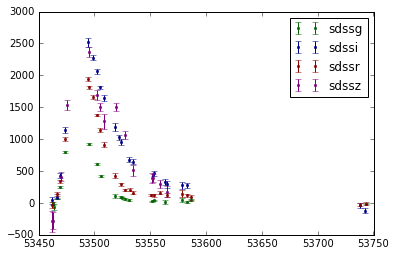

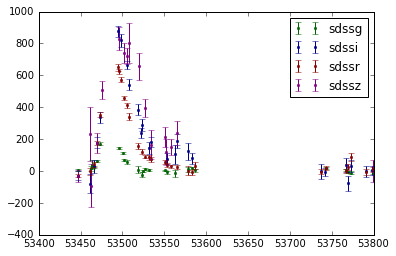

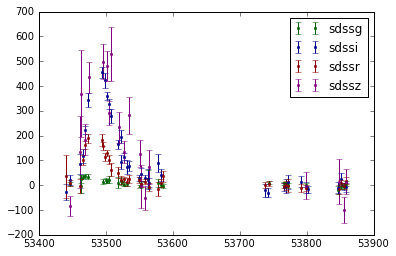

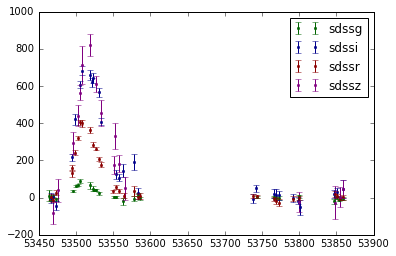

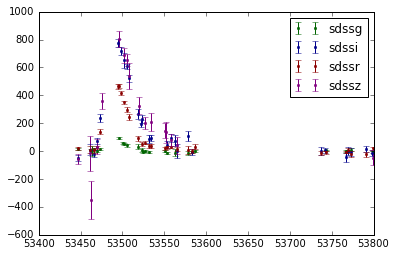

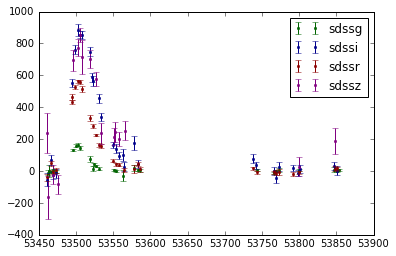

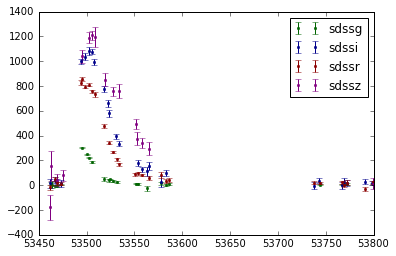

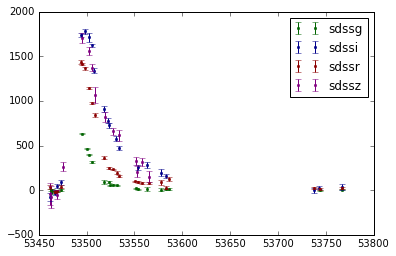

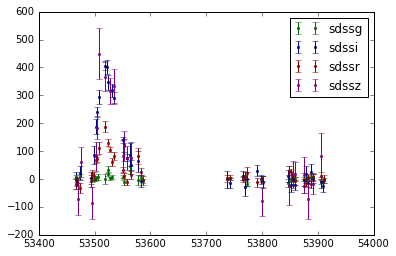

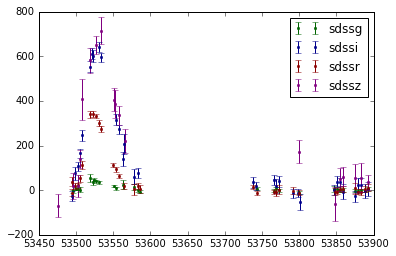

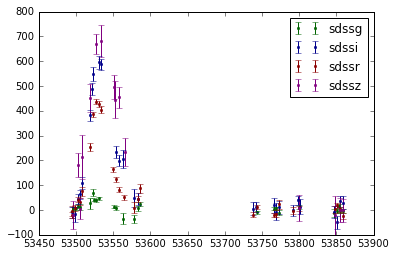

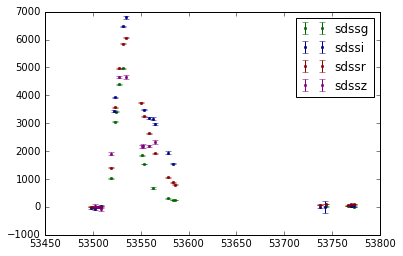

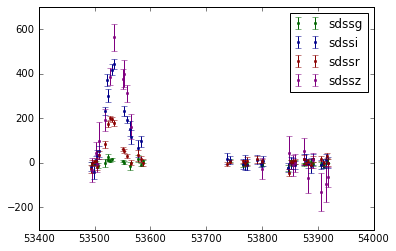

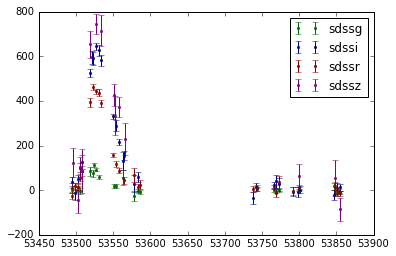

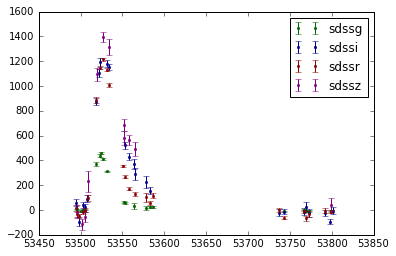

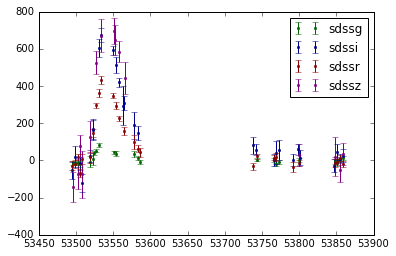

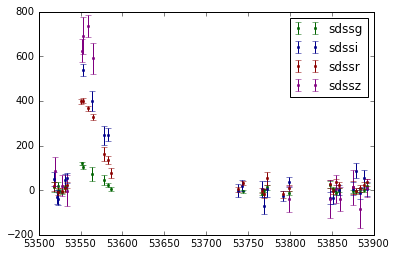

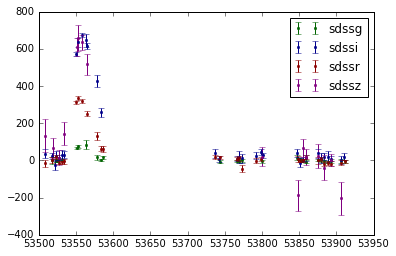

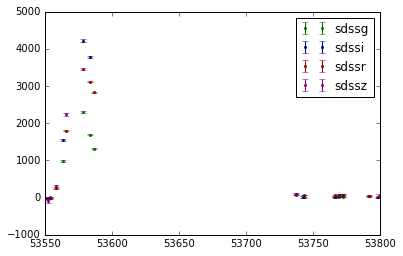

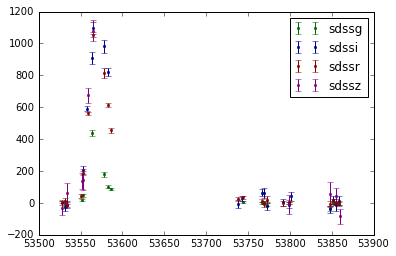

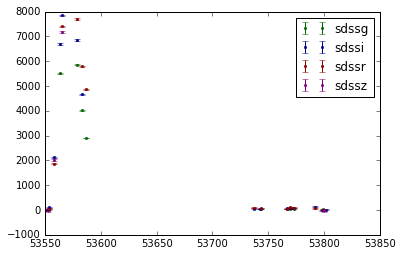

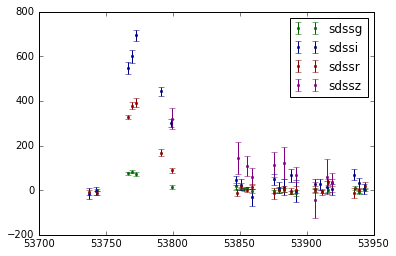

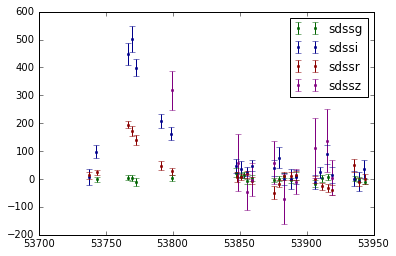

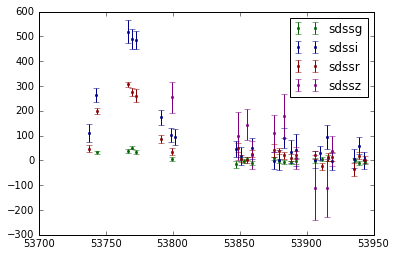

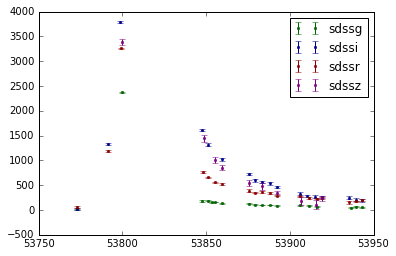

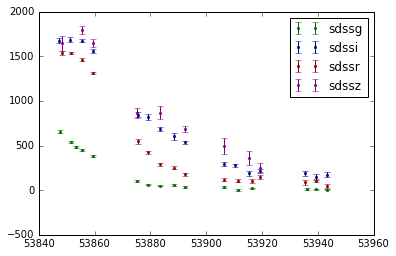

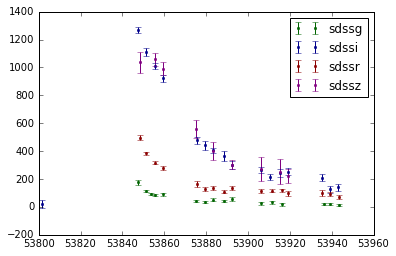

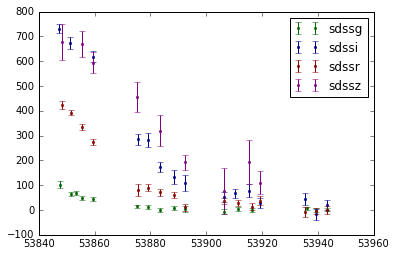

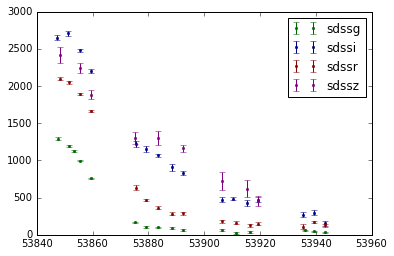

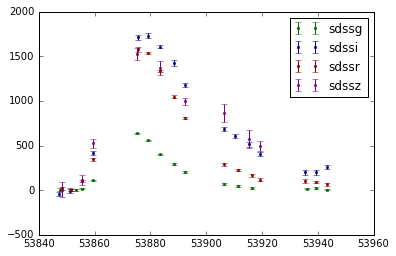

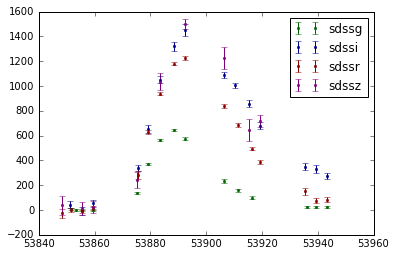

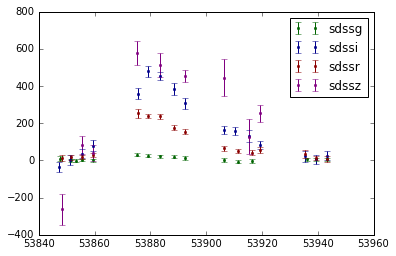

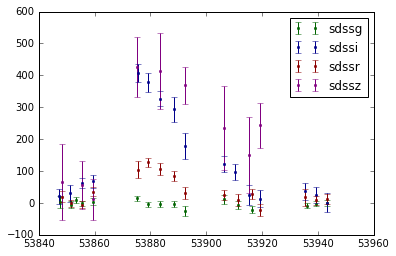

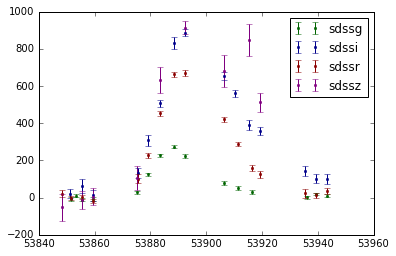

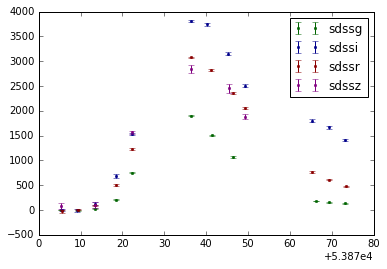

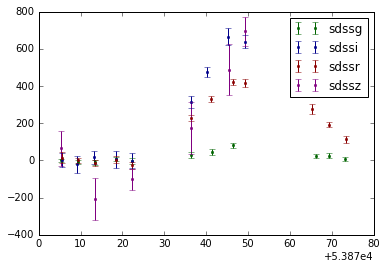

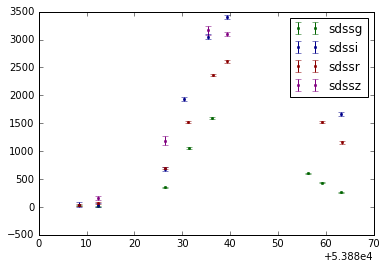

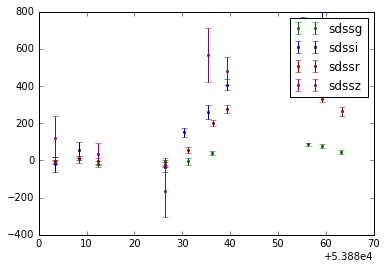

total of sn:75


In [8]:
snls_array = []
for sn in elems:

        c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))

        m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)


        snls_lc = DSTools.build_light_curve_from_snls_file_2(m, c, sn[0], sn[-1])

        if len(m)>0:
            #print sn[0], c.ra.deg, c.dec.deg

            #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
            show_multi_filter_light_curve(snls_lc, snls_colors)
            plt.show()
            snls_array.append(snls_lc)

print("total of sn:" + str(len(snls_array)))


This method opens all the extracted Stack light curves

In [9]:
lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Tests/light_curves_noDup/*.dat")
lcs = []
for oj in lienObj:
    table = ascii.read(oj)
    lcs.append(table)

With this piece of code, we filter light curves with at least 2 curves in the different bands

In [10]:
s_candidates= []
for lc in lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    if len(indices)>=2:
        s_candidates.append(lc)

This also alow us to select only the candidates with at least N points.

In [11]:
res = None
for s in s_candidates:
    if len(s)>10:
        res = s

Opening the control data: SNLS curves

Extracting and building the sncosmo tables from the SNLS data

Matching the SNLS with Stack. Indexes are the matched curves

In [89]:
candidates_copy = copy.deepcopy(s_candidates)

In [12]:
len(s_candidates)

440822

In [16]:
df

,mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass,magnitude,magnitude_error,ID
0,53080.0,6.0,ab,72.388634,3.764254,0.974762,0.923296,30.0,sdssi,25.350824,0.014620,0
1,53083.0,6.0,ab,18.016556,3.764254,0.850242,0.923296,30.0,sdssg,26.860821,0.051238,0
2,53083.0,6.0,ab,82.849670,3.764254,1.209626,0.923296,30.0,sdssi,25.204273,0.015852,0
3,53109.0,6.0,ab,15.385023,3.764255,1.162016,0.923296,30.0,sdssg,27.032255,0.082005,0
4,53138.0,6.0,ab,19.325619,3.764254,0.896431,0.923296,30.0,sdssg,26.784666,0.050363,0
5,53123.0,6.0,ab,63.682358,3.764254,1.684499,0.923296,30.0,sdssr,25.489952,0.028719,0
6,53117.0,6.0,ab,93.475388,3.764254,2.126792,0.923296,30.0,sdssi,25.073257,0.024703,0
7,53094.0,6.0,ab,55.085621,3.764254,1.272105,0.923296,30.0,sdssr,25.647404,0.025073,0
8,53193.0,3.0,ab,87.853180,3.764257,1.695217,0.923296,30.0,sdssi,25.140606,0.020950,0
9,53200.0,6.0,ab,18.276829,3.764254,0.815497,0.923297,30.0,sdssg,26.845248,0.048445,0


In [ ]:
from astropy.table import Column
df = None
for i, candidate in enumerate(s_candidates):
    candidate.add_column(Column([i]*len(candidate), name="ID") )
    if df is None:
        df = candidate.to_pandas()
    else:
        df = df.append(candidate.to_pandas())


In [24]:
s_candidates[1].remove_column("ID")

In [23]:
s_candidates[0]

mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass,magnitude,magnitude_error
float64,float64,str2,float64,float64,float64,float64,float64,str5,float64,float64
53080.0,6.0,ab,72.388633728,3.76425441528,0.974762499332,0.923296058972,30.0,sdssi,25.3508240506,0.014620181126
53083.0,6.0,ab,18.0165557861,3.76425439104,0.850241541862,0.923296004831,30.0,sdssg,26.8608205731,0.0512383185636
53083.0,6.0,ab,82.8496704102,3.76425441258,1.20962631702,0.923296030961,30.0,sdssi,25.2042730373,0.0158520254833
53109.0,6.0,ab,15.3850231171,3.76425475072,1.16201555729,0.923296216106,30.0,sdssg,27.0322546171,0.0820045801323
53138.0,6.0,ab,19.3256187439,3.76425431782,0.896430850029,0.923296127953,30.0,sdssg,26.7846664812,0.0503625494136
53123.0,6.0,ab,63.6823577881,3.76425440917,1.68449854851,0.923296081786,30.0,sdssr,25.4899521639,0.0287194306948
53117.0,6.0,ab,93.4753875732,3.76425443947,2.12679171562,0.923296032531,30.0,sdssi,25.0732568137,0.0247031312261
53094.0,6.0,ab,55.0856208801,3.76425431728,1.27210450172,0.923296059637,30.0,sdssr,25.647404378,0.0250731477959
53193.0,3.0,ab,87.8531799316,3.76425687331,1.69521725178,0.923295920789,30.0,sdssi,25.1406062854,0.0209503941305
